In [1]:
# Installations and Imports
#!pip install wandb tensorflow scikit-learn opencv-python requests


In [2]:

import tensorflow as tf
import numpy as np
import wandb
from wandb.integration.keras import WandbCallback
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import sys
sys.path.append('..')
from model_training.data_loader import QuickDrawDataLoader
from model_training.model import create_cnn_model, compile_model
from model_training.config import MODEL_CONFIG, TRAIN_CONFIG, WANDB_CONFIG

print("All imports successful!")


2025-11-25 15:36:24.929133: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/umakanthprakash/PersonalDocuments/FHTechnikum/Classes/SEM3/SolutionDeployment-Auf/Repositories/Final-Proj/wandb-model-serving/.venv/lib/python3.12/site-packages/wandb/sdk/launch/builder/build.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/umakanthprakash/PersonalDocuments/FHTechnikum/Classes/SEM3/SolutionDeployment-Auf/Repositories/Final-Proj/wandb-model-serving/.venv/lib/python3.12/site-packages/wandb/sdk/launch/builder/buil

All imports successful!


In [3]:
import os

# os.environ['WANDB_API_KEY'] = 'wandbapi-key-here'

os.environ['WANDB_NOTEBOOK_NAME'] = 'train_sketch_model.ipynb'

# Login to W&B
wandb.login()

print("W&B login successful!")

/Users/umakanthprakash/PersonalDocuments/FHTechnikum/Classes/SEM3/SolutionDeployment-Auf/Repositories/Final-Proj/wandb-model-serving/.venv/lib/python3.12/site-packages/wandb/sdk/launch/builder/build.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
wandb: Currently logged in as: testuser-fhtw (fhtw). Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: testuser-fhtw (fhtw). Use `wandb login --relogin` to force relogin


W&B login successful!


## Sketch Recognition - Model Training

This notebook trains a Custom CNN model on the Google QuickDraw dataset for sketch recognition.

### Prerequisites
1. **W&B Account**: Sign up at https://wandb.ai
2. **API Key**: Get from https://wandb.ai/authorize
3. **Update Config**: Set W&B username in `model_training/config.py`

### Steps
1. Import libraries and configure W&B
2. Load QuickDraw dataset (20 categories)
3. Create and train CNN model
4. Evaluate performance
5. Save model for deployment

# Configure W&B


In [4]:
# Initialize W&B with minimal configuration

run = wandb.init(
    project='sketch-recognition',
    name='sketch-cnn-training'
)

print("W&B initialized!")
print(f"Dashboard: {run.get_url()}")

wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


W&B initialized!
Dashboard: https://wandb.ai/fhtw/sketch-recognition/runs/3veipckq


In [5]:
# Load Data
print(" Loading QuickDraw data...")
data_loader = QuickDrawDataLoader()
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_loader.load_data()

print(f"Data loaded:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Validation: {X_val.shape[0]} samples")
print(f"   Test: {X_test.shape[0]} samples")
print(f"   Classes: {len(TRAIN_CONFIG['categories'])}")


 Loading QuickDraw data...
Loaded 15000 samples for apple
Loaded 15000 samples for banana
Loaded 15000 samples for cat
Loaded 15000 samples for banana
Loaded 15000 samples for cat
Loaded 15000 samples for dog
Loaded 15000 samples for house
Loaded 15000 samples for dog
Loaded 15000 samples for house
Loaded 15000 samples for tree
Loaded 15000 samples for car
Loaded 15000 samples for tree
Loaded 15000 samples for car
Loaded 15000 samples for fish
Loaded 15000 samples for bird
Loaded 15000 samples for fish
Loaded 15000 samples for bird
Loaded 15000 samples for clock
Loaded 15000 samples for book
Loaded 15000 samples for clock
Loaded 15000 samples for book
Loaded 15000 samples for chair
Loaded 15000 samples for cup
Loaded 15000 samples for chair
Loaded 15000 samples for cup
Loaded 15000 samples for star
Loaded 15000 samples for star
Loaded 15000 samples for octopus
Loaded 15000 samples for smiley face
Loaded 15000 samples for sun
Loaded 15000 samples for octopus
Loaded 15000 samples for smi

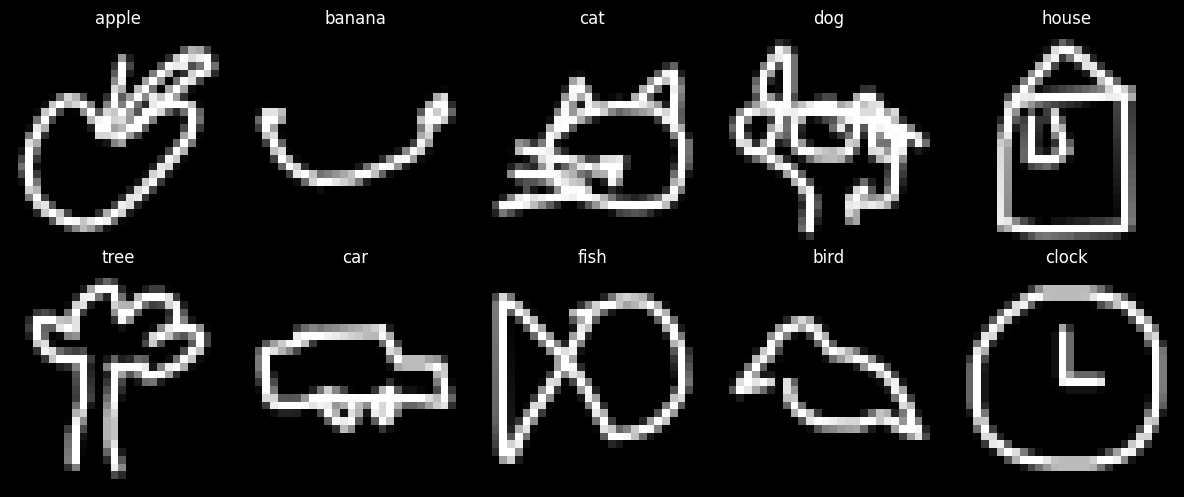

In [6]:

# Visualize Sample Data
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    row, col = i // 5, i % 5
    sample_idx = np.where(y_train == i)[0][0]
    axes[row, col].imshow(X_train[sample_idx].squeeze(), cmap='gray')
    axes[row, col].set_title(TRAIN_CONFIG['categories'][i])
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# Log sample images to W&B
sample_images = []
for i in range(10):
    sample_idx = np.where(y_train == i)[0][0]
    sample_images.append(wandb.Image(X_train[sample_idx].squeeze(), 
                                   caption=TRAIN_CONFIG['categories'][i]))
wandb.log({"sample_sketches": sample_images})



In [7]:
# Create and Compile Model
print(" Creating model...")
model = create_cnn_model()
model = compile_model(model, learning_rate=TRAIN_CONFIG['learning_rate'])

model.summary()



 Creating model...


/Users/umakanthprakash/PersonalDocuments/FHTechnikum/Classes/SEM3/SolutionDeployment-Auf/Repositories/Final-Proj/wandb-model-serving/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,404 (470.33 KB)

 Trainable params: 119,572 (467.08 KB)

 Non-trainable params: 832 (3.25 KB)

In [8]:
#  Setup Callbacks
# Note: Removed WandbCallback due to compatibility issues - using manual logging instead
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    )
]

print("Callbacks configured (W&B will log metrics manually after training)")

Callbacks configured (W&B will log metrics manually after training)


In [9]:
#  Train Model
print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=TRAIN_CONFIG['batch_size'],
    epochs=TRAIN_CONFIG['epochs'],
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

# Log training history to W&B
for epoch in range(len(history.history['loss'])):
    wandb.log({
        'epoch': epoch + 1,
        'loss': history.history['loss'][epoch],
        'accuracy': history.history['accuracy'][epoch],
        'val_loss': history.history['val_loss'][epoch],
        'val_accuracy': history.history['val_accuracy'][epoch]
    })

print("Training metrics logged to W&B")

Starting training...
Epoch 1/20
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 151s 98ms/step - accuracy: 0.5883 - loss: 1.3976 - val_accuracy: 0.7881 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 151s 98ms/step - accuracy: 0.5883 - loss: 1.3976 - val_accuracy: 0.7881 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 155s 104ms/step - accuracy: 0.7521 - loss: 0.8504 - val_accuracy: 0.8344 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 155s 104ms/step - accuracy: 0.7521 - loss: 0.8504 - val_accuracy: 0.8344 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 167s 112ms/step - accuracy: 0.7845 - loss: 0.7433 - val_accuracy: 0.8508 - val_loss: 0.4956 - learning_rate: 0.0010
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 167s 112ms/step - accuracy: 0.7845 - loss: 0.7433 - val_accuracy: 0.8508 - val_loss: 0.4956 - learning_rate: 0.0010
Epoch 4/20
1500/1500 ━

In [10]:
# Evaluate Model
print("Evaluating model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Log final metrics to W&B
wandb.log({
    'final_accuracy': test_accuracy,
    'final_loss': test_loss,
    'best_val_accuracy': max(history.history['val_accuracy'])
})



Evaluating model...
Test Accuracy: 0.8900
Test Loss: 0.3651
Test Accuracy: 0.8900
Test Loss: 0.3651


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Classification Report:
              precision    recall  f1-score   support

       apple       0.97      0.96      0.96      3000
      banana       0.90      0.81      0.85      3000
         cat       0.80      0.81      0.81      3000
         dog       0.71      0.73      0.72      3000
       house       0.97      0.96      0.97      3000
        tree       0.90      0.93      0.92      3000
         car       0.92      0.94      0.93      3000
        fish       0.93      0.90      0.91      3000
        bird       0.79      0.73      0.76      3000
       clock       0.93      0.96      0.94      3000
        book       0.89      0.94      0.92      3000
       chair       0.91      0.93      0.92      3000
         cup       0.92      0.87      0.90      3000
        star       0.93      0.94      0.94      3000
     octopus       0.93      0.91      0.92      3000
 smiley face       0.94   

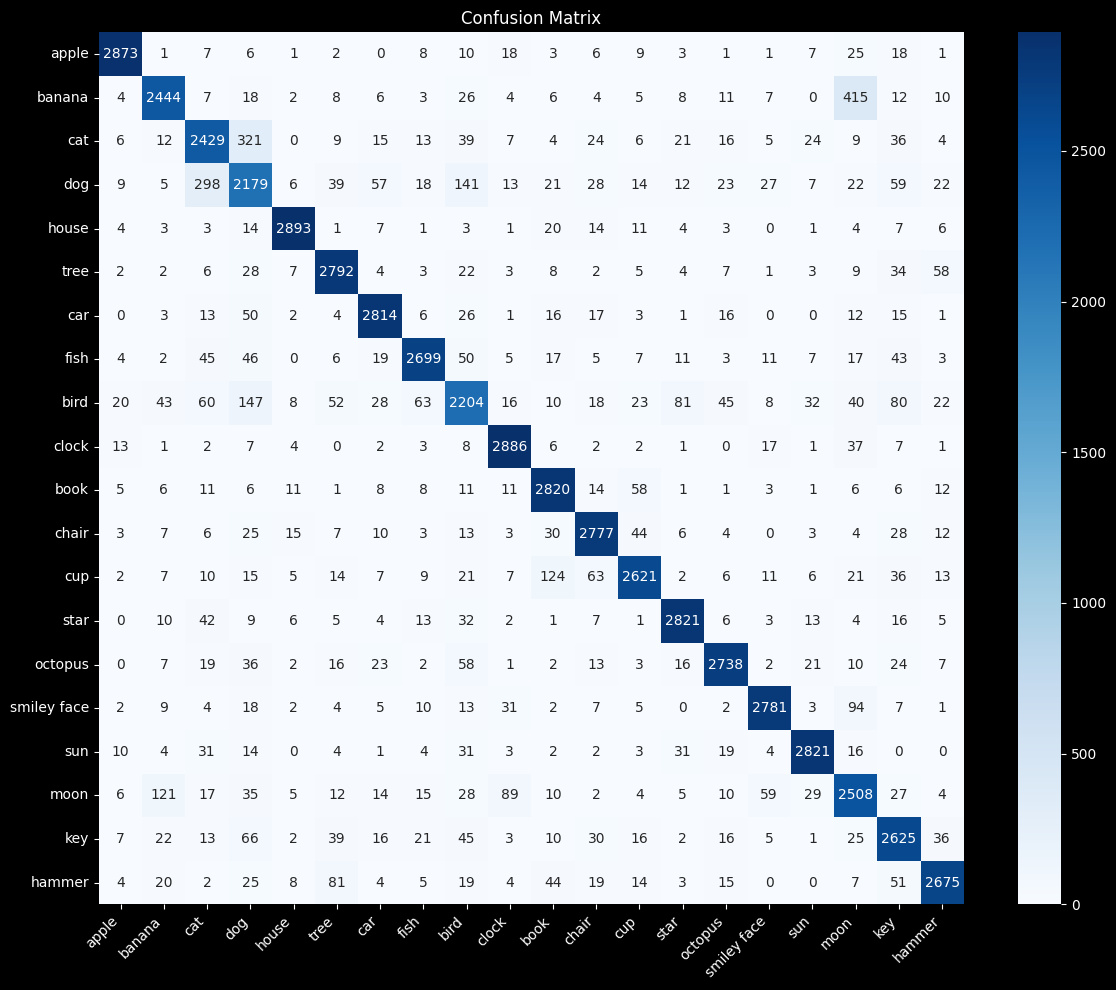

In [11]:
# Generate Predictions and Detailed Metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique classes present in test set
unique_classes = np.unique(np.concatenate([y_test, y_pred_classes]))
target_names_filtered = [TRAIN_CONFIG['categories'][i] for i in unique_classes]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, 
                          labels=unique_classes,
                          target_names=target_names_filtered))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_filtered,
            yticklabels=target_names_filtered)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Log confusion matrix to W&B
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_test,
    preds=y_pred_classes,
    class_names=TRAIN_CONFIG['categories']
)})

In [15]:
#Save Model
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save model in H5 format
model_path_h5 = '../models/sketch_model.h5'
model.save(model_path_h5)
print(f"Model saved to: {model_path_h5}")

model_path_pb = '../models/pb_sketch_model'
model.export(model_path_pb)
print(f"Model saved to: {model_path_pb} (SavedModel format)")

# Also save to W&B as an artifact
artifact = wandb.Artifact('sketch_model', type='model')
artifact.add_file(model_path_h5)
artifact.add_dir(model_path_pb)
run.log_artifact(artifact)
print(" Model uploaded to W&B as artifact (both formats)")

Model saved to: ../models/sketch_model.h5
INFO:tensorflow:Assets written to: ../models/pb_sketch_model/assets
INFO:tensorflow:Assets written to: ../models/pb_sketch_model/assets


INFO:tensorflow:Assets written to: ../models/pb_sketch_model/assets


Saved artifact at '../models/pb_sketch_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  5649378832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649378256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649374800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649380944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649381520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649381328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649379600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649381904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649380560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649379984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5649379792: TensorSpec(shape=(), dtype=tf.resource, name

wandb: Adding directory to artifact (./../models/pb_sketch_model)... Done. 0.0s
Done. 0.0s


Model saved to: ../models/pb_sketch_model (SavedModel format)
 Model uploaded to W&B as artifact (both formats)
 Model uploaded to W&B as artifact (both formats)


In [16]:
# Test Inference
import sys
sys.path.append('..')
from deployment.inference import SketchPredictor

# Test with the saved model
predictor = SketchPredictor('../models/sketch_model.h5')

# Test with a random sample
sample_idx = 42
test_image = X_test[sample_idx].squeeze() * 255
true_label = TRAIN_CONFIG['categories'][y_test[sample_idx]]

predictions = predictor.predict(test_image)

print(f"Inference Test:")
print(f"   True label: {true_label}")
print(f"   Top predictions:")
for i, pred in enumerate(predictions, 1):
    print(f"   {i}. {pred['category']}: {pred['confidence']:.2f}%")

Inference Test:
   True label: book
   Top predictions:
   1. book: 95.42%
   2. cup: 3.83%
   3. chair: 0.22%


In [ ]:
# Finish W&B Run
wandb.finish()
print("All done! Model trained and saved successfully!")